In [1]:
import pandas as pd
import numpy as np
from numpy import nan
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
brca = pd.read_csv('/Users/junetam/Desktop/STAT432/Final Project/brca_data_w_subtypes.csv')
brca.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Columns: 1941 entries, rs_CLEC3A to histological.type
dtypes: float64(827), int64(1110), object(4)
memory usage: 10.4+ MB


In [3]:
PR_Status = brca['PR.Status']
ER_Status = brca['ER.Status'] 
HER2 = brca['HER2.Final.Status']
HIST = brca['histological.type']

brca_variables = brca.drop(['vital.status', 'PR.Status', 'ER.Status', 'HER2.Final.Status', 'histological.type'], axis=1)
brca_outcomes = brca[['vital.status', 'PR.Status', 'ER.Status', 'HER2.Final.Status', 'histological.type']]
brca_variables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Columns: 1936 entries, rs_CLEC3A to pp_p90RSK.pT359.S363
dtypes: float64(827), int64(1109)
memory usage: 10.4 MB


In [4]:
test = brca_variables.iloc[:, 0:20]


<AxesSubplot:xlabel='rs_CPB1'>

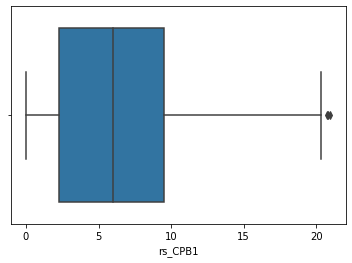

In [5]:
sns.boxplot(brca_variables.iloc[:,1])

### Identifying any missing values for features

In [51]:
x = brca_variables.isnull().sum()
x[x!=0]

Series([], dtype: int64)

#### It is good that there is no missing value appeared for all the features in the dataset, so we could move forward for further analysis on this data.
According to the data description on Kaggle, there are four groups of features, which are `mu` (somatic mutation (yes, no)), `cn` (copy number variation as calculated by gistic (-2,-1,0,1,2)), `rs` (rna sequencing i.e. gene expression) and `pp` (phospho-protein levels). 

To get an in-depth understanding of our data, we need to check the balence between different categories for each categorical variable (`mu` and `cn`) and identify outliers for continuous variables (`rs` and `pp`).

In [59]:
filter_col_mu = [col for col in brca_variables if col.startswith('mu')]
filter_col_cn = [col for col in brca_variables if col.startswith('cn')]
filter_col_rs = [col for col in brca_variables if col.startswith('rs')]
filter_col_pp = [col for col in brca_variables if col.startswith('pp')]
brca_variables_mu = brca_variables[filter_col_mu]
brca_variables_cn = brca_variables[filter_col_cn]
brca_variables_rs = brca_variables[filter_col_rs]
brca_variables_pp = brca_variables[filter_col_pp]

### Check balance between each category for categorical predictors:
#### For `mu` and `cn` continuous variables, we need to the disturbution of observations' response for each category that might affect the prediction effect for later modeling.

In [237]:
## Check balance between each category for mu variables
def check_balance(df2):
    col = []
    for column in df2:
        if df2.loc[:,column].value_counts()[0] - df2.loc[:,column].value_counts()[1] > 0:
            dif = df2.loc[:,column].value_counts()[1]/df2.loc[:,column].value_counts()[0]
            if dif < 0.05:
                col.append(column)
        else:
            dif = df2.loc[:,column].value_counts()[0]/df2.loc[:,column].value_counts()[1]
            if dif < 0.05:
                col.append(column)
    return col

In [214]:
brca_variables_mu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Columns: 249 entries, mu_ANK3 to mu_PEG3
dtypes: int64(249)
memory usage: 1.3 MB


In [238]:
len(check_balance(brca_variables_mu))

228

#### By looking at the frequency of the two categories of  `mu`  binary  variables, a vast majority of these variables are unbalanced. 228 out of 249 variables have less than a ratio of 5:100 of frequency.

In [271]:
## Check balance between each category for cn variables
def check_balance_1(df2):
    col = []
    for column in df2:
        if df2.loc[:,column].value_counts().max() - df2.loc[:,column].value_counts().min() > 400:
            col.append(column)
    return col

In [272]:
len(check_balance_1(brca_variables_cn))

185

In [247]:
brca_variables_cn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Columns: 860 entries, cn_ISG15 to cn_MLC1
dtypes: int64(860)
memory usage: 4.6 MB


#### By looking at the frequency disturbution of the five categories of  `cn` categorical variables, also, a vast majority of these variables are unbalanced. 

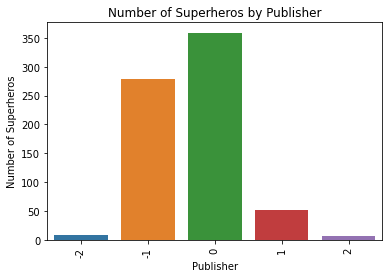

In [241]:
sns.countplot(x='cn_ISG15', data=brca_variables_cn)
plt.title('Number of Superheros by Publisher')
plt.ylabel('Number of Superheros')
plt.xlabel('Publisher')
plt.xticks(rotation = 90)
plt.show();

### Identifying outliers for continuous predictors:
#### For `rs` and `pp` continuous variables, we need to check the existence of outliers that might affect the prediction effect for later modeling.

In [18]:
## Identifying variables with outliners, and their corresponding number of outliers
def identify_outlier(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final, len(df_final)
def find_col(df2):
    col = []
    num = []
    for column in df2:
        if identify_outlier(df2.loc[:,column])[1] != 0:
            col.append(column)
            num.append(identify_outlier(df2.loc[:,column])[1])
    res = {col[i]: num[i] for i in range(len(col))}
    return res

In [181]:
#find_col(brca_variables_rs)
#len(brca_variables_rs) 705
#len(find_col(brca_variables_rs)) 325

In [80]:
def getList(dict):
    return list(dict.keys())

In [88]:
rs_outliers = getList(find_col(brca_variables_rs))
# list of columns with outliers
rs_outliers_num = list(find_col(brca_variables_rs). values())
# list of numbers of outliers
brca_variables_rs_outliers = brca_variables_rs[rs_outliers]

In [180]:
pd_rs_outliers = pd.DataFrame(find_col(brca_variables_rs).items())
#pd_rs_outliers[((pd_rs_outliers[1] < 50) & (pd_rs_outliers[1] > 45)) | (pd_rs_outliers[1] > 100)].sort_values(by=[1])
#new_df = pd_rs_outliers.sort_values(by=[1]).head(2).append(pd_rs_outliers[((pd_rs_outliers[1] > 47) & (pd_rs_outliers[1] < 50))]).append(pd_rs_outliers.sort_values(by=[1]).tail(2))
#new_df.sort_values(by=[1])

In [182]:
bins = [0, 10, 100, 500]
rs_ol_counts = pd.cut(pd_rs_outliers.iloc[:,1], bins)
pd.value_counts(rs_ol_counts)

(0, 10]       176
(10, 100]     141
(100, 500]      8
Name: 1, dtype: int64

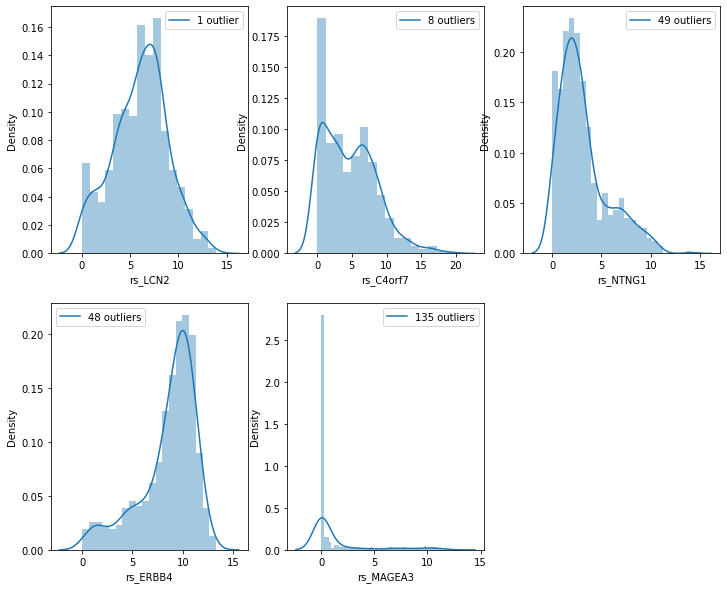

In [179]:
plt.figure(figsize=(12,10))
plt.subplot(2,3,1)
sns.distplot(brca_variables_rs['rs_LCN2'])
plt.legend(labels=['1 outlier'])
plt.subplot(2,3,2)
sns.distplot(brca_variables_rs['rs_C4orf7'])
plt.legend(labels=['8 outliers'])
plt.subplot(2,3,3)
sns.distplot(brca_variables_rs['rs_NTNG1'])
plt.legend(labels=['49 outliers'])
plt.subplot(2,3,4)
sns.distplot(brca_variables_rs['rs_ERBB4'])
plt.legend(labels=['48 outliers'])
plt.subplot(2,3,5)
sns.distplot(brca_variables_rs['rs_MAGEA3'])
plt.legend(labels=['135 outliers'])
plt.show()

#### For `rs` variables, we have 325 variables out of 705 that have outliers. And half of these variables has only fewer than 10 observations deviated markedly from others in the sample, which might be erroneously recored, we are considering simply dropping those observations.

In [127]:
#pd_rs_outliers.sort_values(pd_rs_outliers[1])
pd_rs_outliers.sort_values(by=[1])

,0,1
82,rs_LCN2,1
187,rs_VIPR2,1
32,rs_KLK6,1
283,rs_TNNT3,1
280,rs_TNNI3,1
...,...,...
182,rs_CARTPT,111
125,rs_HORMAD1,112
58,rs_MAGEA6,120
10,rs_GSTT1,126


In [117]:
pd_pp_outliers = pd.DataFrame(find_col(brca_variables_pp).items())
pd_pp_outliers

,0,1
0,pp_X14.3.3.beta,28
1,pp_X14.3.3.epsilon,36
2,pp_X14.3.3.zeta,17
3,pp_X4E.BP1,32
4,pp_X4E.BP1.pS65,14
...,...,...
217,pp_p62.LCK.ligand,16
218,pp_p70S6K,49
219,pp_p70S6K.pT389,33
220,pp_p90RSK,10


In [118]:
bins = [0, 10, 50, 100, 500]
pp_ol_counts = pd.cut(pd_pp_outliers.iloc[:,1], bins)
pd.value_counts(pp_ol_counts)

(10, 50]      162
(0, 10]        34
(50, 100]      25
(100, 500]      1
Name: 1, dtype: int64

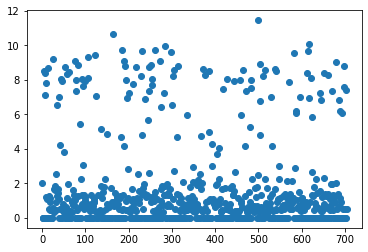

In [133]:
plt.scatter(brca_variables_rs.index, brca_variables_rs['rs_HORMAD1'])
plt.show()

(array([549.,  37.,  18.,  15.,   4.,  19.,  16.,  10.,  27.,  10.]),
 array([ 0.        ,  1.20798112,  2.41596223,  3.62394335,  4.83192446,
         6.03990558,  7.24788669,  8.45586781,  9.66384892, 10.87183004,
        12.07981115]),
 <BarContainer object of 10 artists>)

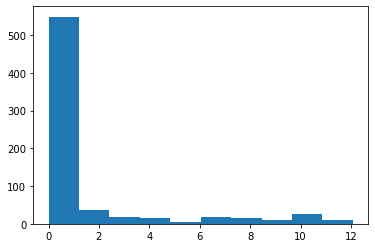

In [141]:
plt.hist(brca_variables_rs['rs_MAGEA3'])

<AxesSubplot:ylabel='Density'>

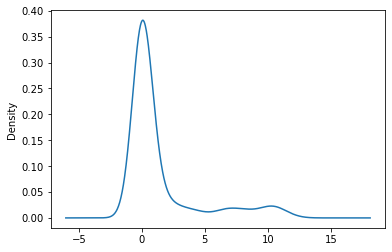

In [140]:
brca_variables_rs['rs_MAGEA3'].plot(kind='density')

In [102]:
from sklearn import preprocessing
scaler = preprocessing.Normalizer()
scaled_df = scaler.fit_transform(brca_variables_rs['rs_MYBPC1'].values.reshape(-1,1))
scaled_df

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],

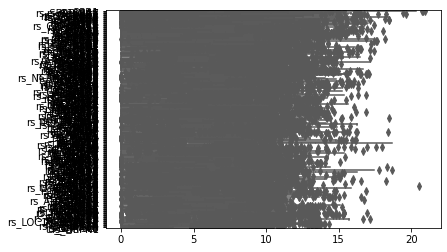

In [86]:
ax = sns.boxplot(data=brca_variables_rs_outliers, orient="h", palette="Set2")

In [73]:
len(brca_variables_pp)

705

In [74]:
len(find_col(brca_variables_pp))

222